In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys
import math

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer as Vit, PatchEmbed, Block

2023-05-20 14:43:41.536331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 14:43:41.633953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-20 14:43:41.633972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-20 14:43:41.660399: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-20 14:43:42.065187: W tensorflow/stream_executor/platform/de

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [180]:
collect()
torch.cuda.empty_cache()
torch.set_printoptions(precision=6)
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


In [3]:
vit = Vit(dspl_size=104, 
          patch_size=8, 
          embed_dim=128,
          depth=4,
          n_heads=4,
          mlp_ratio=1.0,
          qkv_bias=False,
          p=0.1,
          attn_p=0.1,
          drop_path=0.).float()

path_to_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-final_2023-May-16 19:56:24/ViT-final_2023-May-16 19:56:24.pth'

vit.load_state_dict(torch.load(path_to_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [4]:
class Backbone(nn.Module):
    def __init__(self,dspl_size=104,patch_size=8,embed_dim=2*104,depth=12,n_heads=12,mlp_ratio=4.,qkv_bias=False,p=0.,attn_p=0,drop_path=0.1,):
        super().__init__()
        self.patch_embed = PatchEmbed(dspl_size, patch_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p)
        dpr = [x.item() for x in torch.linspace(0, drop_path, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                    drop_path=dpr[i]
                )
                for i in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-7)
    
    def forward(self, x, return_attention=False):
        x = self.patch_embed(x)
        x = x + self.pos_embed  # (n_samples, n_patches, embed_dim)
        x = self.pos_drop(x)
        
        for i, block in enumerate(self.blocks):
            x = block(x, return_attention)

        x = self.norm(x)

        return x

In [5]:
class RecTracHead2(nn.Module):
    def __init__(self, in_dim, patch_size=8):
        super().__init__()

        #layers = [nn.Linear(in_dim, in_dim), nn.GELU(), nn.Linear(in_dim, in_dim), nn.GELU()]

        #self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.convTrans1 = nn.ConvTranspose2d(in_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.GeLu1 = nn.GELU()
        self.convTrans2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.GeLu2 = nn.GELU()
        self.convTrans3 = nn.ConvTranspose2d(32, 2, kernel_size=3, stride=2, padding=1, output_padding=1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x_rec = x.transpose(1, 2)
        out_sz = tuple((int(math.sqrt(x_rec.size()[2])), int(math.sqrt(x_rec.size()[2]))))
        x_rec = self.convTrans1(x_rec.unflatten(2, out_sz))
        x_rec = self.GeLu1(x_rec)
        x_rec = self.convTrans2(x_rec)
        x_rec = self.GeLu2(x_rec)
        x_rec = self.convTrans3(x_rec)

        return x_rec

In [6]:
proj = vit.patch_embed.proj

In [7]:
patch_embed = vit.patch_embed
pos_embed = vit.pos_embed
blocks = vit.blocks
norm = vit.norm
rec_trac_head = vit.rec_trac_head

In [8]:
backbone = Backbone(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=4,
              n_heads=4,
              mlp_ratio=1.,
              p=0.05,
              attn_p=0.05,
              drop_path=0.).float()

In [10]:
backbone.load_state_dict(torch.load(path_to_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=False)   

_IncompatibleKeys(missing_keys=[], unexpected_keys=['rec_trac_head.convTrans1.weight', 'rec_trac_head.convTrans1.bias', 'rec_trac_head.convTrans2.weight', 'rec_trac_head.convTrans2.bias', 'rec_trac_head.convTrans3.weight', 'rec_trac_head.convTrans3.bias'])

In [11]:
dspl_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements.h5', 'r')['dspl'][1])
trac_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions.h5', 'r')['trac'][1])
#dspl_test = np.concatenate([dspl_test[i] for i in range(dspl_test.shape[0])], axis=0, dtype=np.float32)
#trac_test = np.concatenate([trac_test[i] for i in range(trac_test.shape[0])], axis=0, dtype=np.float32)

In [12]:
sigma = 0.005 * np.mean(np.var(dspl_test, axis=(1, 2, 3)))
cov = [[sigma,0],[0, sigma]]
noise_0 = None
for i, x in tqdm(enumerate(dspl_test), desc='noised'):
    noise = np.random.default_rng().multivariate_normal(mean=[0, 0], cov=cov, size=(104, 104))
    if i == 0:
        noise_0 = noise
    dspl_test[i] = x + noise

noised: 50it [00:00, 1629.68it/s]


In [13]:
X_test = torch.from_numpy(np.moveaxis(dspl_test, 3, 1)).float()
Y_test = torch.from_numpy(np.moveaxis(trac_test, 3, 1)).float()

In [42]:
real_cells = []
real_dspl = torch.zeros((15, 2, 104, 104))
directory = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl'

for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        real_cell = {}
        file = loadmat(directory+'/'+filename)
        real_cell['brdx'] = np.rot90(file['brdx'], 2)
        real_cell['brdy'] = np.rot90(file['brdy'], 2)
        real_cell['dspl'] = torch.tensor((1 / 200.2) * np.transpose(file['dspl']))
        print(real_cell['dspl'].unsqueeze(0).float().shape)
        real_dspl[i] = real_cell['dspl'].unsqueeze(0).float()
        real_cell['vit_pred'] = vit(real_cell['dspl'].unsqueeze(0).float()) * 10670
        #real_cell['cnn_pred'] = cnn.predict(np.expand_dims(np.moveaxis(np.array(real_cell['dspl']), 0, 2), 0)) * 10670
        real_cells.append(real_cell)

torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])
torch.Size([1, 2, 104, 104])


In [43]:
first_conv = rec_trac_head.convTrans1
snd_conv = rec_trac_head.convTrans2
third_conv = rec_trac_head.convTrans3

In [44]:
real_dspl.shape

torch.Size([15, 2, 104, 104])

<IPython.core.display.Javascript object>


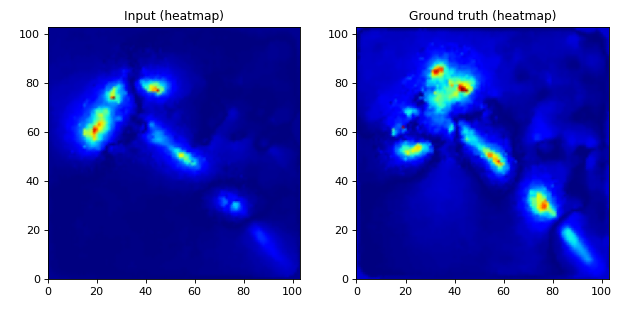

Text(0.5, 1.0, 'Ground truth (heatmap)')

In [45]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

C = np.sqrt((real_cells[0]['dspl'][0, :, :]).detach().numpy() ** 2)
axs[0].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0].set_title('Input (heatmap)', {'fontsize': 11})

C = np.sqrt((real_cells[0]['dspl'][1, :, :]).detach().numpy() ** 2)
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Ground truth (heatmap)', {'fontsize': 11})

In [46]:
project = proj(real_dspl).flatten(2).transpose(1,2)
#project = project + vit.pos_embed

In [47]:
vit.patch_embed.proj.weight.shape

torch.Size([128, 2, 8, 8])

<IPython.core.display.Javascript object>


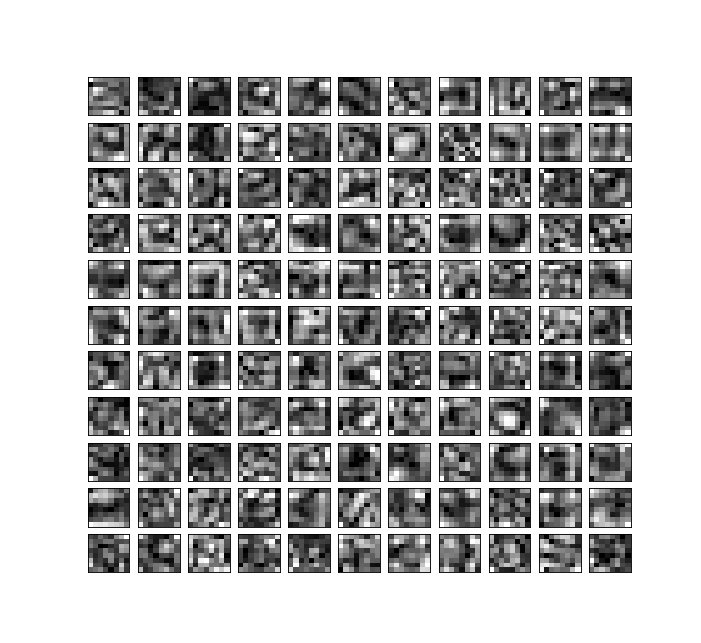

In [48]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 11
ix = 1
for j in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #C = np.sqrt(project[0, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        tok = vit.patch_embed.proj.weight[ix-1].detach().numpy()
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='gray')
        #ax.quiver(tok[0], tok[1], scale=1)
        ix += 1
# show the figure
plt.show()

In [49]:
project.shape

torch.Size([15, 169, 128])

<IPython.core.display.Javascript object>


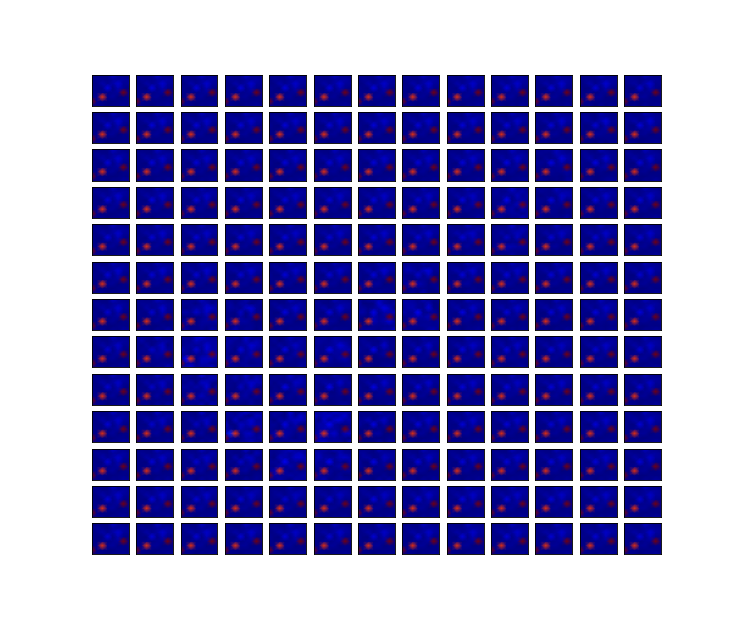

In [50]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 13
ix = 1
for j in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #C = np.sqrt(project[0, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        tok = project[0, ix-1, :]
        tok = np.reshape(tok.detach().numpy(), (2, 8, 8), order='c')
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        #ax.quiver(tok[0], tok[1], scale=1)
        ix += 1
# show the figure
plt.show()

In [51]:
after_block_1 = vit.blocks[0](project)

<IPython.core.display.Javascript object>


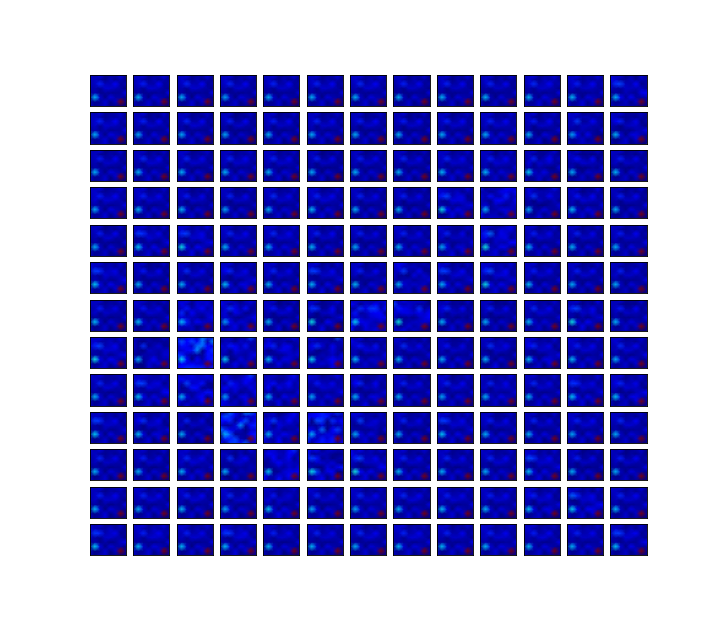

In [52]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 13
ix = 1
for j in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #C = np.sqrt(project[0, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        tok = after_block_1[0, ix-1, :]
        tok = np.reshape(tok.detach().numpy(), (2, 8, 8), order='c')
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        #ax.quiver(tok[0], tok[1], scale=1)
        ix += 1
# show the figure
plt.show()

In [53]:
after_block_2 = vit.blocks[1](after_block_1)

<IPython.core.display.Javascript object>


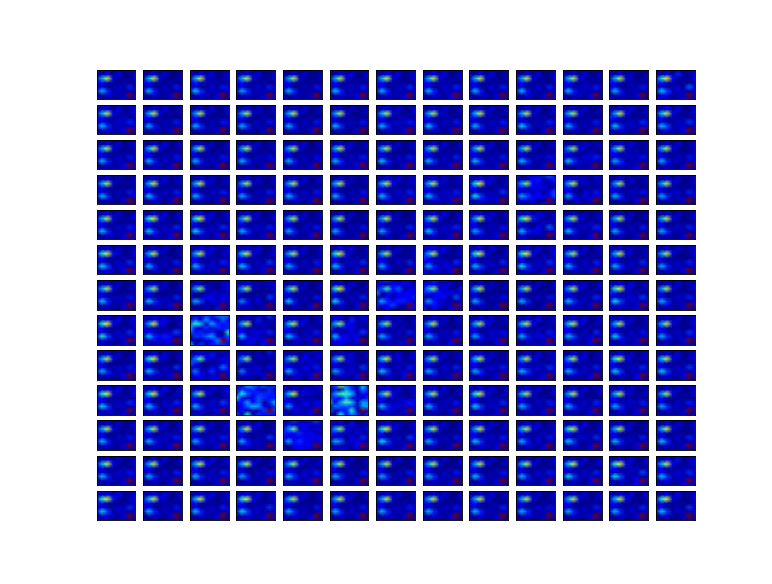

In [54]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 13
ix = 1
for j in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #C = np.sqrt(project[0, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        tok = after_block_2[0, ix-1, :]
        tok = np.reshape(tok.detach().numpy(), (2, 8, 8), order='c')
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        #ax.quiver(tok[0], tok[1], scale=1)
        ix += 1
# show the figure
plt.show()

In [55]:
after_block_3 = vit.blocks[2](after_block_2)

<IPython.core.display.Javascript object>


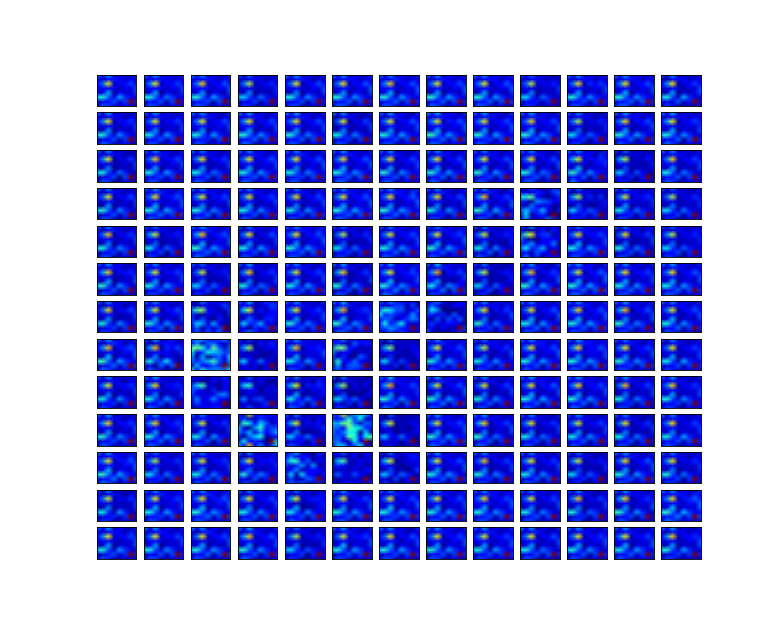

In [56]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 13
ix = 1
for j in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #C = np.sqrt(project[0, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        tok = after_block_3[0, ix-1, :]
        tok = np.reshape(tok.detach().numpy(), (2, 8, 8), order='c')
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        #ax.quiver(tok[0], tok[1], scale=1)
        ix += 1
# show the figure
plt.show()

In [57]:
after_block_4 = vit.blocks[3](after_block_3)

<IPython.core.display.Javascript object>


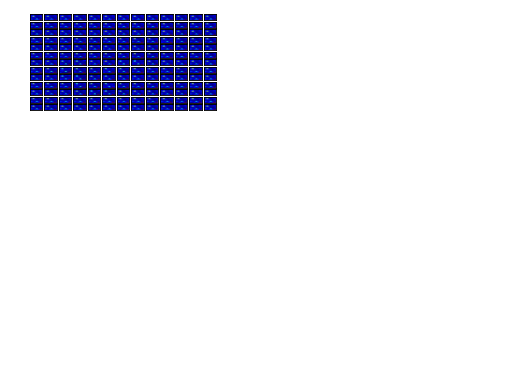

In [58]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 13
ix = 1
for j in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #C = np.sqrt(project[0, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        tok = after_block_4[0, ix-1, :]
        tok = np.reshape(tok.detach().numpy(), (2, 8, 8), order='c')
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        #ax.quiver(tok[0], tok[1], scale=1)
        ix += 1
# show the figure
plt.show()

In [59]:
after_norm = vit.norm(after_block_4)

<IPython.core.display.Javascript object>


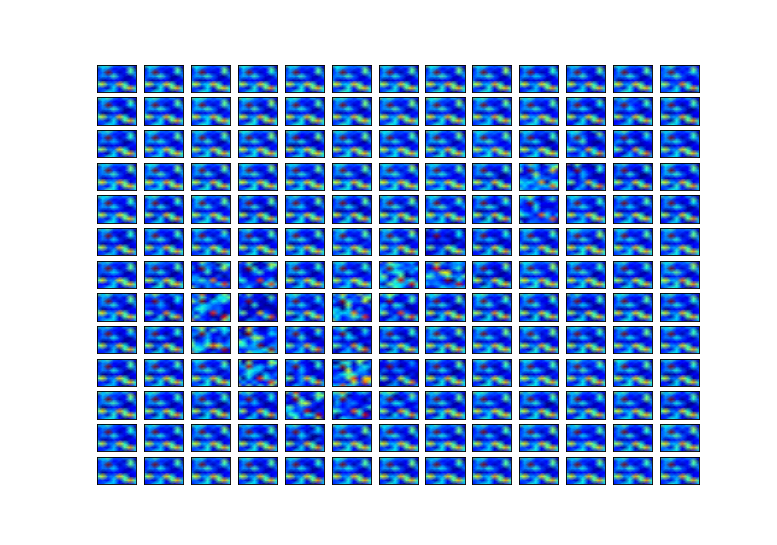

In [60]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 13
ix = 1
for j in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #C = np.sqrt(project[0, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        tok = after_norm[0, ix-1, :]
        tok = np.reshape(tok.detach().numpy(), (2, 8, 8), order='c')
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        #ax.quiver(tok[0], tok[1], scale=1)
        ix += 1
# show the figure
plt.show()

In [61]:
after_conv1 = nn.GELU()(vit.rec_trac_head.convTrans1(after_norm.transpose(1,2).unflatten(2, (13,13))))

<IPython.core.display.Javascript object>


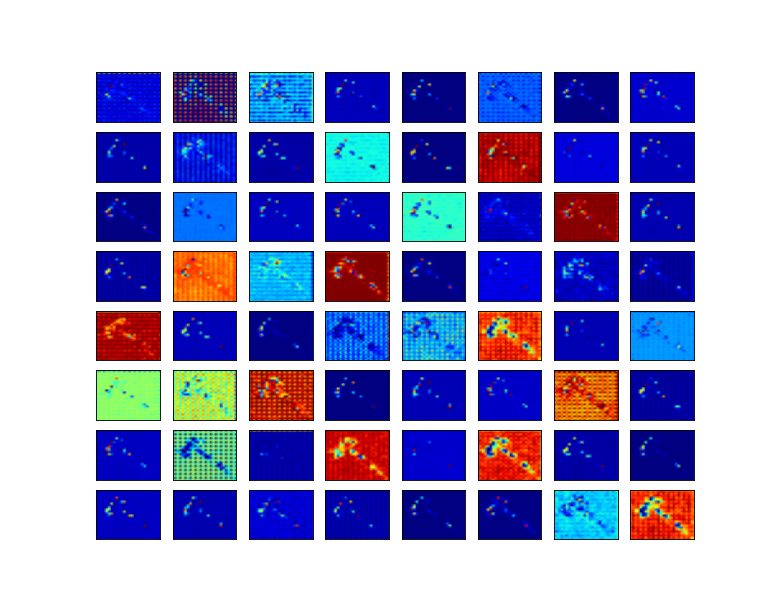

In [62]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        tok = after_conv1[0, ix-1, :, :]
        C = np.sqrt(tok.detach().numpy() ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        #C = np.sqrt(backbone_feature_maps[2, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        ix += 1
        """
        C = np.sqrt(backbone_feature_maps[2, 2, :, :].detach().numpy() **2)
        axs[1, 0].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[1, 0].set_title('ViT prediction (heatmap)', {'fontsize': 11})
        """
# show the figure
plt.show()

In [63]:
after_conv2 = nn.GELU()(vit.rec_trac_head.convTrans2(after_conv1))

<IPython.core.display.Javascript object>


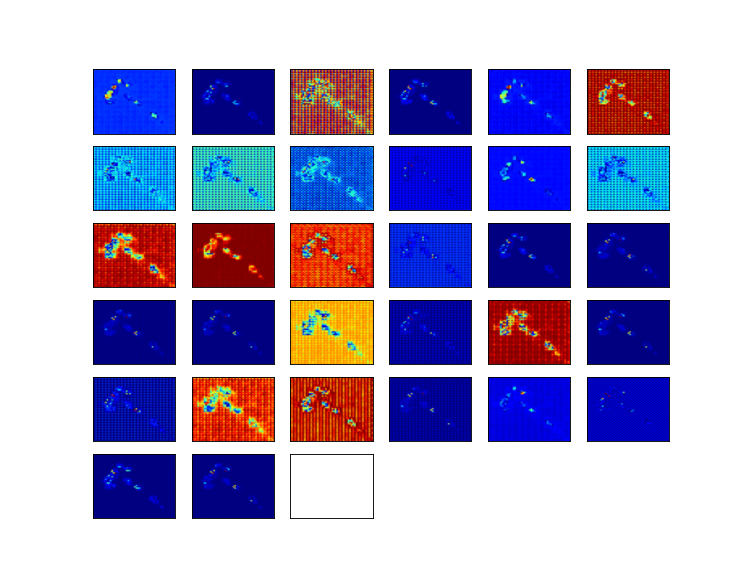

IndexError: index 32 is out of bounds for dimension 1 with size 32

In [64]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 6
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        tok = after_conv2[0, ix-1, :, :]
        C = np.sqrt(tok.detach().numpy() ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        #C = np.sqrt(backbone_feature_maps[2, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        ix += 1
        """
        C = np.sqrt(backbone_feature_maps[2, 2, :, :].detach().numpy() **2)
        axs[1, 0].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[1, 0].set_title('ViT prediction (heatmap)', {'fontsize': 11})
        """
# show the figure
plt.show()

In [65]:
after_conv3 = vit.rec_trac_head.convTrans3(after_conv2)

<IPython.core.display.Javascript object>


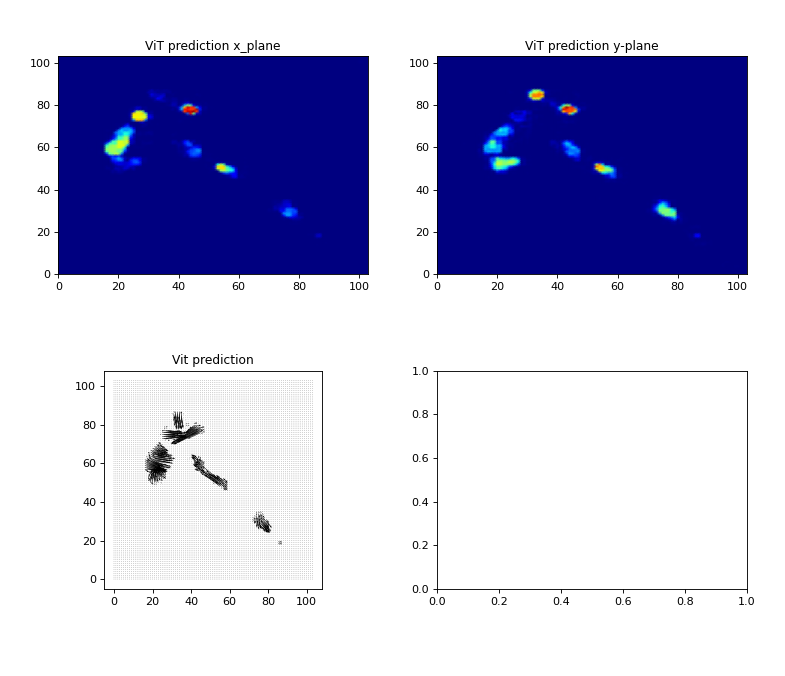

In [69]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(8, 4))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

C = np.sqrt(after_conv3[0, 0, :, :].detach().numpy() **2)
axs[0, 0].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0, 0].set_title('ViT prediction x_plane', {'fontsize': 11})

C = np.sqrt(after_conv3[0, 1, :, :].detach().numpy() **2)
axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0, 1].set_title('ViT prediction y-plane', {'fontsize': 11})

axs[1, 0].quiver(after_conv3[0, 0, :, :].detach().numpy(), after_conv3[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 0].set_title(f'Vit prediction', {'fontsize': 11})
#axs[1, 0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0])
axs[1, 0].set_aspect('equal')

<IPython.core.display.Javascript object>


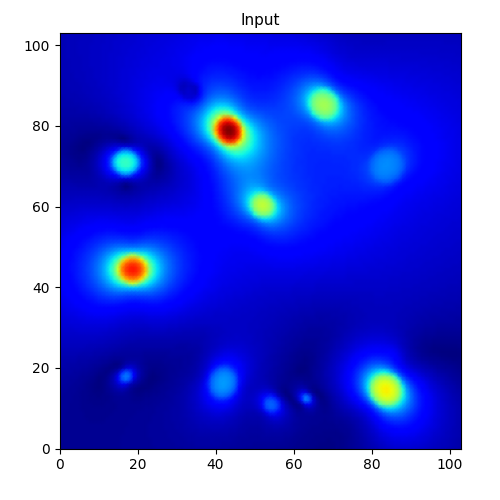

Text(0.5, 1.0, 'Input')

In [218]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

C = np.sqrt(X_test[2, 0, :, :].detach().numpy() ** 2 + X_test[2, 1, :, :].detach().numpy() ** 2)
axs.pcolormesh(C, cmap='jet', shading='gouraud')
axs.set_title('Input', {'fontsize': 11})

__Step 0__ : Feature maps after ViT backbone

In [234]:
backbone_feature_maps = backbone(X_test).transpose(1,2)
#backbone_feature_maps = backbone_feature_maps.unflatten(2, (13, 13))
backbone_feature_maps.shape

torch.Size([50, 128, 169])

<IPython.core.display.Javascript object>


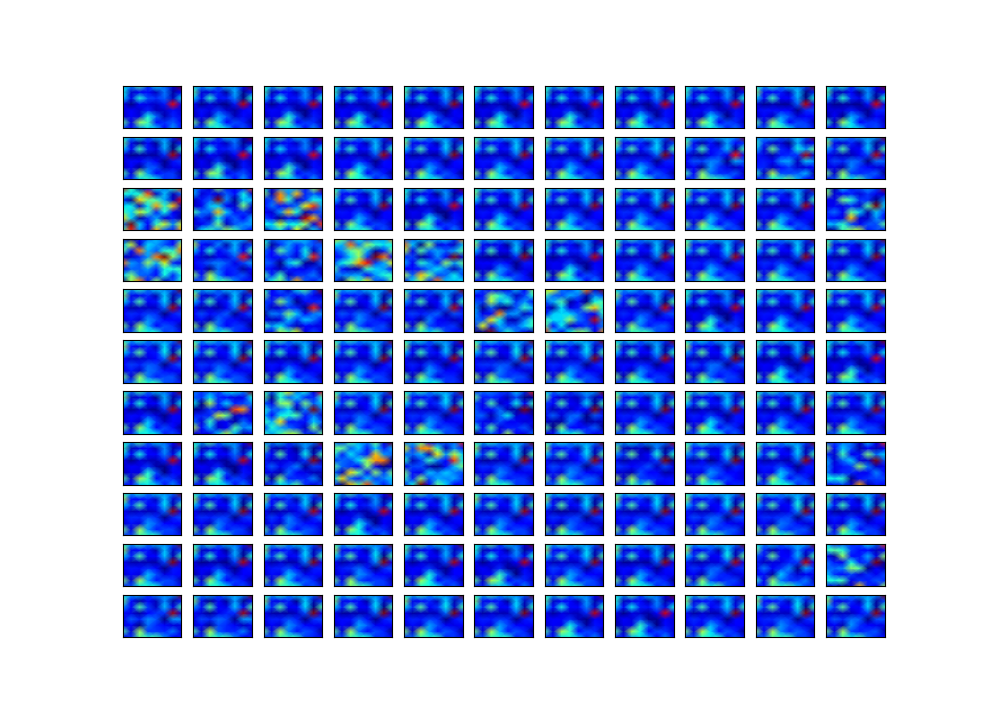

In [239]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 11
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        C = np.sqrt(conv2_feature_maps[2, ix-1, :, :].detach().numpy() **2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        # plot filter channel in grayscale
        #C = np.sqrt(backbone_feature_maps[2, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        ix += 1
        """
        C = np.sqrt(backbone_feature_maps[2, 2, :, :].detach().numpy() **2)
        axs[1, 0].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[1, 0].set_title('ViT prediction (heatmap)', {'fontsize': 11})
        """
# show the figure
plt.show()

Step 1

In [242]:
conv1_feature_maps = nn.GELU()(first_conv(backbone_feature_maps.unflatten(2, (13, 13))))

In [243]:
conv1_feature_maps.shape

torch.Size([50, 64, 26, 26])

<IPython.core.display.Javascript object>


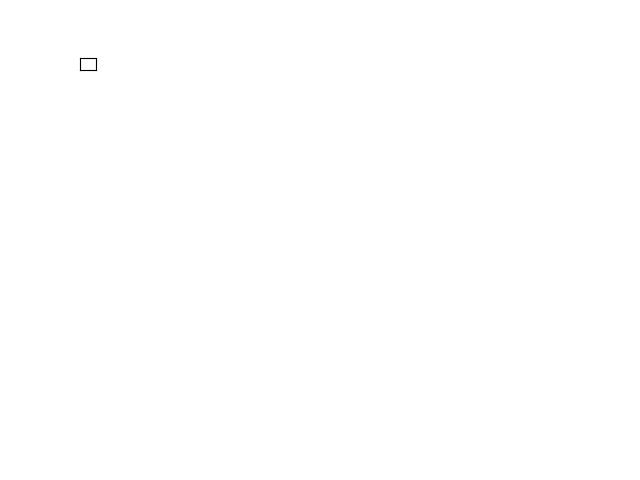

ValueError: cannot reshape array of size 64 into shape (2,4,4)

In [244]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 26
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        tok = conv1_feature_maps.flatten(2)[0, :, ix-1]
        tok = np.reshape(tok.detach().numpy(), (2, 4, 4), order='c')
        C = np.sqrt(tok[0] ** 2 + tok[1] ** 2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        #C = np.sqrt(conv1_feature_maps[2, ix-1, :, :].detach().numpy() **2)
        #ax.pcolormesh(C, cmap='jet', shading='gouraud')
        ix += 1
        """
        C = np.sqrt(backbone_feature_maps[2, 2, :, :].detach().numpy() **2)
        axs[1, 0].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[1, 0].set_title('ViT prediction (heatmap)', {'fontsize': 11})
        """
# show the figure
plt.show()

Step 2

In [245]:
conv2_feature_maps = nn.GELU()(snd_conv(conv1_feature_maps))

In [246]:
conv2_feature_maps.shape

torch.Size([50, 32, 52, 52])

<IPython.core.display.Javascript object>


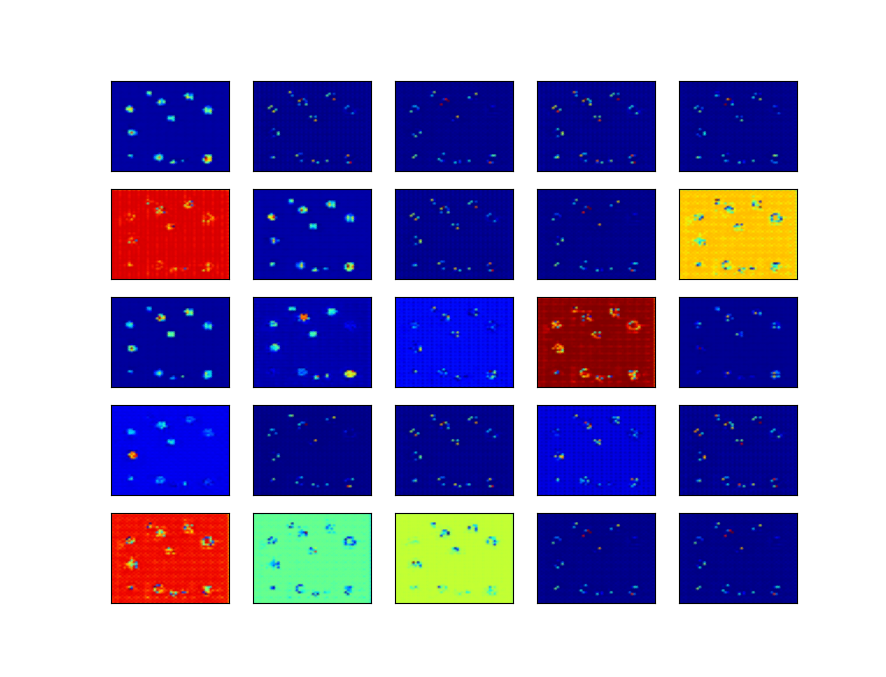

In [204]:
get_ipython().run_line_magic('matplotlib', 'notebook')

square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        C = np.sqrt(conv2_feature_maps[2, ix-1, :, :].detach().numpy() **2)
        ax.pcolormesh(C, cmap='jet', shading='gouraud')
        ix += 1
        """
        C = np.sqrt(backbone_feature_maps[2, 2, :, :].detach().numpy() **2)
        axs[1, 0].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[1, 0].set_title('ViT prediction (heatmap)', {'fontsize': 11})
        """
# show the figure
plt.show()

Step 3

In [205]:
conv3_feature_maps = third_conv(conv2_feature_maps)

<IPython.core.display.Javascript object>


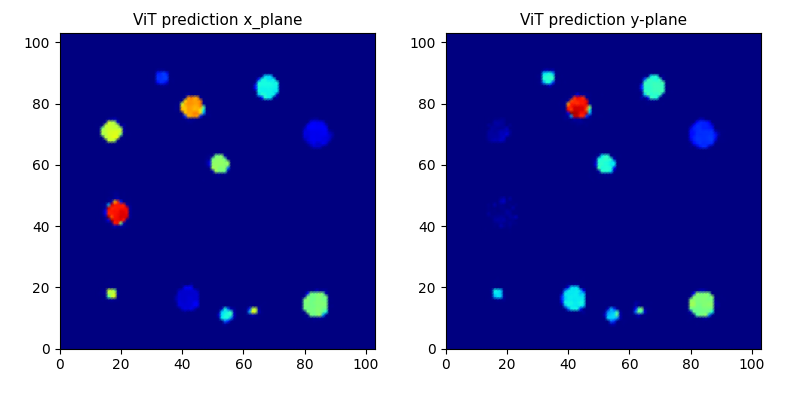

Text(0.5, 1.0, 'ViT prediction y-plane')

In [207]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

C = np.sqrt(conv3_feature_maps[2, 0, :, :].detach().numpy() **2)
axs[0].pcolormesha(C, cmap='jet', shading='gouraud')
axs[0].set_title('ViT prediction x_plane', {'fontsize': 11})

C = np.sqrt(conv3_feature_maps[2, 1, :, :].detach().numpy() **2)
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('ViT prediction y-plane', {'fontsize': 11})